# Define genomic bins based on LD structure
### Yosuke Tanigawa (2017/7/5)

## ToDo
- replace path to PLINK log file


## Summary:
This note describes the following procedures:
1. `PLINK --blocks` command to generate .block.det file
1. Definition of genomic bins based on the LD block structure

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import bisect

font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

In [2]:
def show_block_statistics(block_size_kb, block_size_nSNPs):
    """ visualize the size of blocks (length, # SNPs) with mean/median
    """
    print('size of blocks: \tmean = {:.2f}kb;\tmedian = {:.2f}kb'.format(
        np.mean(block_size_kb), np.median(block_size_kb)
    ))
    print('#SNPs in blocks:\tmean = {:.2f};\tmedian = {:.2f}'.format(
        np.mean(block_size_nSNPs), np.median(block_size_nSNPs)
    ))    
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2)
    axs = [fig.add_subplot(ss) for ss in gs]
    axs[0].hist(block_size_kb)
    axs[1].hist(block_size_nSNPs)
    axs[0].set_xlabel('size of the LD block (kbp)')
    axs[1].set_xlabel('size of the LD block (# SNPs)')
    for ax in axs:
        ax.set_ylabel('frequency')
    axs[0].set_title('Size of blocks')
    axs[1].set_title('# SNPs in blocks')
    fig.suptitle('')
    gs.tight_layout(fig, rect=[0, 0, 1, 0.88])    

In [3]:
def define_bins(chrom, bim, block_det):
    """Define LD-based bins
    Note: the input files (bim file and block_det file) are 1-indexed
    """
    
    # find genomic positions that consist the boundaries of bins
    interval_points = np.zeros(len(block_det) + 1, dtype=np.int)
    interval_points[1:-1] = [x - 1 for x in block_det.BP1.as_matrix()[1:]]
    interval_points[0] = bim.pos[0] - 1
    interval_points[-1] = bim.pos[len(bim) -1] - 1    
    
    # convert to 0-index coordinate
    bim_pos_0index = bim.pos.map(lambda x: x - 1).as_matrix()
    
    # we also want to store the intervals on bim-id space
    interval_points_bimid = np.array(
        [bisect.bisect_right(bim_pos_0index, x) - 1 for x in interval_points]
    )    
    
    # create a data frame
    bins_df = pd.DataFrame({
        'block_id': range(len(block_det)),
        'chrom': [chrom] * len(block_det),
        'chromStart': interval_points[:-1],
        'chromEnd':   interval_points[1:],
        'bimIdStart': interval_points_bimid[:-1],
        'bimIdEnd':   interval_points_bimid[1:]
    })    
    
    bins_df['KB']    = 1.0 * (bins_df.chromEnd - bins_df.chromStart) / 1000
    bins_df['nSNPs'] = bins_df.bimIdEnd - bins_df.bimIdStart
    
    return bins_df[['block_id', 'chrom', 'chromStart', 'chromEnd', 'bimIdStart', 'bimIdEnd', 'KB', 'nSNPs']]

## 0) input & output files
### input

In [4]:
block_det_f = '../../../../public_data/intermediate/population_ref/chr20-alleles.blocks.det'
bim_f = '../../../../public_data/intermediate/population_ref/chr20-alleles.bim'

### output

In [5]:
bins_f = '../../../../public_data/intermediate/population_ref/chr20-bins.tsv'

## 1) PLINK --blocks command
- We used plink 1.9 --blocks option to compute the LD blocks
- https://www.cog-genomics.org/plink2/ld

In [6]:
!cat /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/unphased_data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/private_data/ukbb/pgen/chr20impv1
  --biallelic-only strict
  --geno
  --hwe 1e-10 midp
  --keep /share/PI/mrivas/data/ukbb/phefiles/initialdata/1389.phe
  --maf 0.005
  --make-bed
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --snps-only just-acgt

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:24:21 2017

Random number seed: 1498260261
257674 MB RAM detected; reserving 30000 MB for main workspace.
1540220 out of 1619597 variants loaded from .bim file.
152249 people (0 males, 0 females, 152249 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.nosex
.
--keep: 112338 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Befo

In [7]:
!cat /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/unphased_data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --blocks no-pheno-req no-small-max-span
  --blocks-inform-frac 0.10
  --blocks-max-kb 1000
  --blocks-recomb-highci 0.830001
  --blocks-strong-highci 0.830001
  --blocks-strong-lowci 0.50001
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:32:58 2017

Random number seed: 1498260778
257674 MB RAM detected; reserving 30000 MB for main workspace.
198418 variants loaded from .bim file.
112338 people (0 males, 0 females, 112338 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-bl

### The mean and median of size and # SNPs
- Here, SNPs with 5% + is used to define our blocks

### blocks.det file
- the results of the PLINK 1.9 --blocks command is shown below:

In [8]:
block_det = pd.read_csv(block_det_f, sep='\s+')
print(block_det.shape)
block_det.head()

(642, 6)


,CHR,BP1,BP2,KB,NSNPS,SNPS
0,20,62731,93931,31.201,30,rs34147676|rs6139074|rs1418258|rs13043000|rs60...
1,20,94952,266511,171.560,545,rs1857092|rs80192833|rs6052070|rs6515824|rs605...
2,20,266792,287529,20.738,56,rs6137140|rs6082182|rs6082191|rs6082211|rs6075...
3,20,288776,344195,55.420,86,rs4815163|rs62191394|rs6075996|rs6082956|rs723...
4,20,344631,345864,1.234,4,rs6084202|rs2017171|rs1555318|rs6051490


size of blocks: 	mean = 91.54kb;	median = 25.41kb
#SNPs in blocks:	mean = 194.97;	median = 50.00


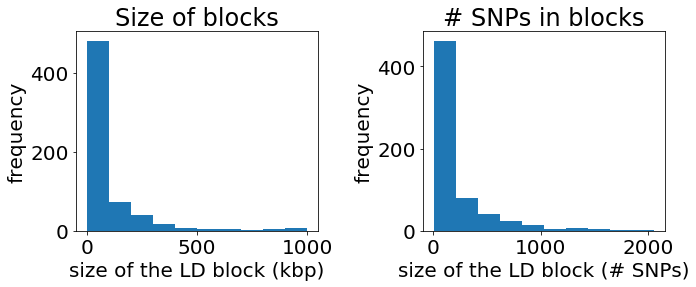

In [9]:
show_block_statistics(block_det.KB, block_det.NSNPS)

## 2) Definition of genomic bins based on the LD block structure
### motivation
- The blocks we found in the previous step does not fully cover the entire chromosome

### method
- Given the block.det file and bim file (that has all the SNPs we consider), we *define* LD-based bins
- block.det is essentially a list of intervals [[BP1_1, BP2_1), [BP1_2, BP2_2), ... , [BP1_n, BP2_n)]
  - [x, y) denotes semi-open intervals where x is included in the interval while y isn't
- Our definition of the blocks are: [[0, BP1_2), [BP1_2, BP1_3), [BP1_3, BP1_4), ... , [BP1_{n-1}, BP1_n), [BP1_{n-1}, end_of_chromosome]]

In [10]:
bim = pd.read_csv(bim_f, sep='\t', names=['chr', 'rsid', 'genetic_dist', 'pos', 'a1', 'a2'])
print(bim.shape)
bim.head()

(198418, 6)


,chr,rsid,genetic_dist,pos,a1,a2
0,20,rs6078030,0,61098,T,C
1,20,rs143291093,0,61270,C,A
2,20,rs4814683,0,61795,T,G
3,20,rs34147676,0,62731,A,C
4,20,rs6076506,0,63231,G,T


In [11]:
bins_df = define_bins('chr20', bim, block_det)

In [12]:
bins_df.head()

,block_id,chrom,chromStart,chromEnd,bimIdStart,bimIdEnd,KB,nSNPs
0,0,chr20,61097,94951,0,78,33.854,78
1,1,chr20,94951,266791,78,915,171.840,837
2,2,chr20,266791,288775,915,991,21.984,76
3,3,chr20,288775,344630,991,1218,55.855,227
4,4,chr20,344630,346675,1218,1224,2.045,6


In [13]:
bins_df.to_csv(bins_f, index=False, sep='\t')

In [14]:
!echo $bins_f

../../../../public_data/intermediate/population_ref/chr20-bins.tsv


size of blocks: 	mean = 97.98kb;	median = 27.01kb
#SNPs in blocks:	mean = 309.06;	median = 88.00


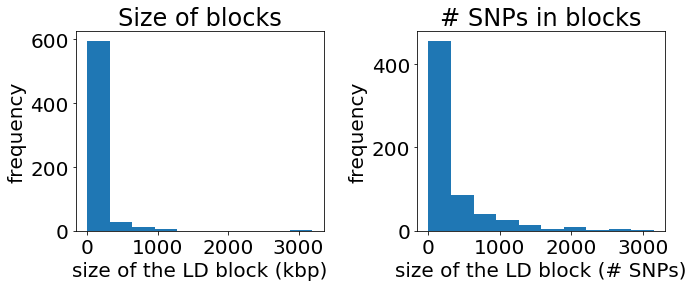

In [15]:
show_block_statistics(bins_df.KB, bins_df.nSNPs)

### The smallest blocks ( top 5 )

In [16]:
bins_df.sort_values(by='KB').head()

,block_id,chrom,chromStart,chromEnd,bimIdStart,bimIdEnd,KB,nSNPs
56,56,chr20,2751793,2751854,10388,10391,0.061,3
500,500,chr20,54542621,54542871,165996,166000,0.250,4
457,457,chr20,51691670,51691988,155359,155363,0.318,4
589,589,chr20,59562076,59562419,184160,184164,0.343,4
483,483,chr20,52822248,52822641,159539,159542,0.393,3


In [17]:
bins_df.sort_values(by='nSNPs').head()

,block_id,chrom,chromStart,chromEnd,bimIdStart,bimIdEnd,KB,nSNPs
89,89,chr20,4959653,4962437,18715,18718,2.784,3
21,21,chr20,889903,890348,3480,3483,0.445,3
235,235,chr20,17484856,17485853,63912,63915,0.997,3
259,259,chr20,19832791,19833436,72881,72884,0.645,3
483,483,chr20,52822248,52822641,159539,159542,0.393,3


### The largest blocks (top 5)

In [18]:
bins_df.sort_values(by='KB', ascending=False).head()

,block_id,chrom,chromStart,chromEnd,bimIdStart,bimIdEnd,KB,nSNPs
294,294,chr20,26285873,29479933,92200,92240,3194.060,40
310,310,chr20,34445163,35449879,102848,104273,1004.716,1425
293,293,chr20,25285219,26285873,90220,92200,1000.654,1980
296,296,chr20,29526084,30526402,92343,94529,1000.318,2186
306,306,chr20,32538390,33538520,98914,100545,1000.130,1631


In [19]:
bins_df.sort_values(by='nSNPs', ascending=False).head()

,block_id,chrom,chromStart,chromEnd,bimIdStart,bimIdEnd,KB,nSNPs
245,245,chr20,18068618,18845538,66150,69299,776.920,3149
415,415,chr20,47219067,48079897,140231,143186,860.830,2955
378,378,chr20,44098541,44759160,129690,132413,660.619,2723
204,204,chr20,13689238,14546034,49761,52389,856.796,2628
338,338,chr20,39635188,40577745,116010,118631,942.557,2621
